#  Example of analysis if WHALES output for SARAL

In [35]:
import sys
PATH_with_functions = '~/TOOLS/cci_whales/src'
sys.path.append(PATH_with_functions)

import numpy as np
import xarray as xr

# --- plotting and interactive stuff ----------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import fftconvolve

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

from altimeters_parameters import alti_read_l2lr,alti_read_l2hrw

import matplotlib.pyplot as plt
import scipy.io
import os
import pathlib

import time


## 1. Reading a GDR file and making some basic plots to know where the data is 

Text(0.5, 0, 'latitude')

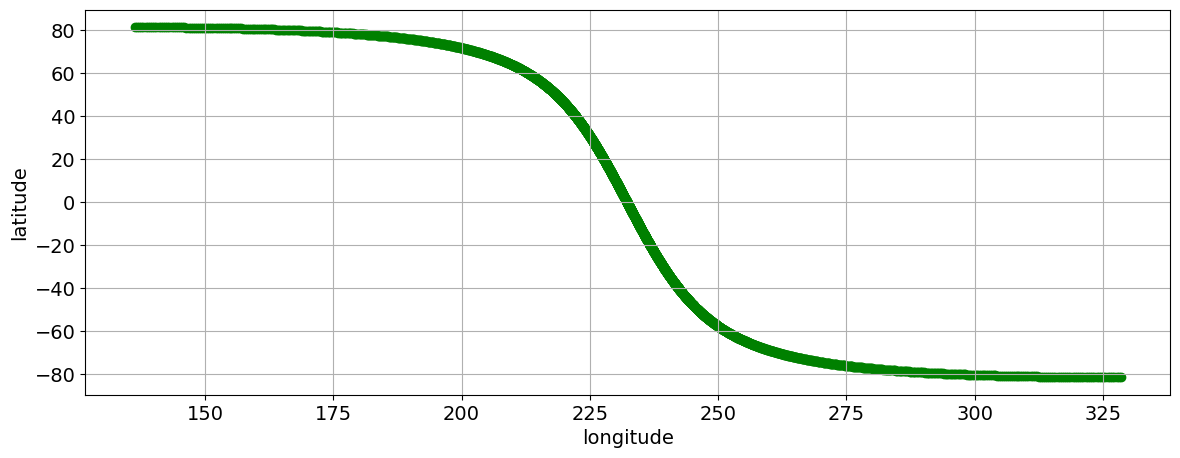

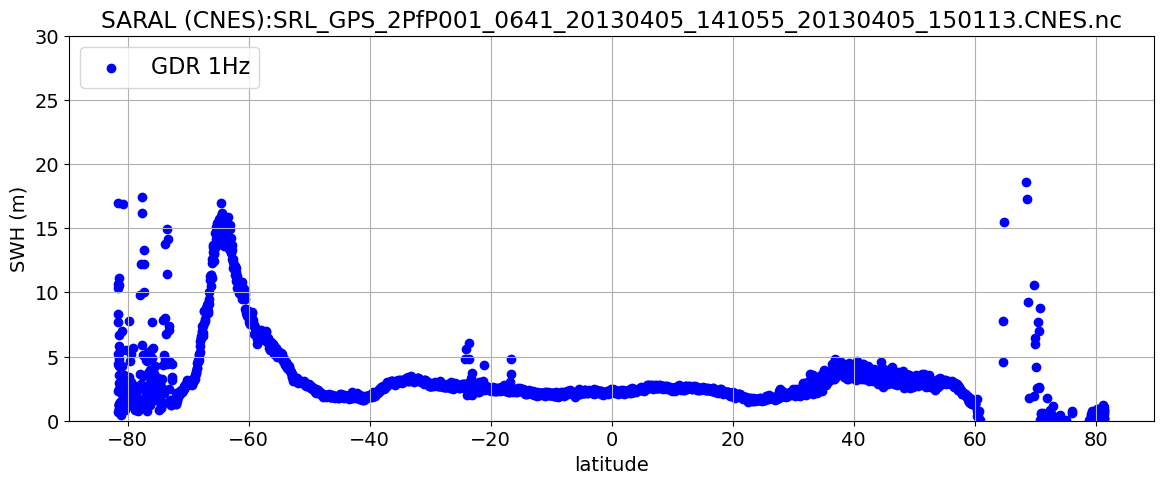

In [36]:

file='SRL_GPS_2PfP029_0496_20151206_123531_20151206_132549.CNES.nc'  # this is a "bad" file with bad values of the mispoiting
file='SRL_GPS_2PfP001_0641_20130405_141055_20130405_150113.CNES.nc'  # this is a good file 
#file='SRL_IPS_2PfP188_0326_20241221_051506_20241221_060523.CNES.nc'  # good file from storm Jesus (up to Hs=15 m) 
#file='SRL_IPS_2PfP188_0311_20241220_164048_20241220_173105.CNES.nc'

# First a few plots of the 1 Hz data to know where we are ... 

Sgd=alti_read_l2lr('saral',file)

#S_landmask = np.ma.getdata(S.variables['surface_type'][:])


inds=np.where((np.isfinite(Sgd.swh_1hz)==1))[0]  # &  (S_landmask==0))[0]

fig,axs = plt.subplots(1,1,figsize=(14,5))
ax = axs
im=ax.scatter(Sgd.lon_1hz[inds],Sgd.lat_1hz[inds],c='g',label='GDR')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')


fig,axs = plt.subplots(1,1,figsize=(14,5))
ax = axs
im=ax.scatter(Sgd.lat_1hz[inds],Sgd.swh_1hz[inds],c='b',label='GDR 1Hz')
ax.legend(loc='upper left', fontsize=16)
ax.set_ylim([0,30])
#ax.set_xlim(lat_bounds) 
ax.set_ylabel('SWH (m)')
ax.set_title('SARAL (CNES):'+file)
ax.set_xlabel('latitude')


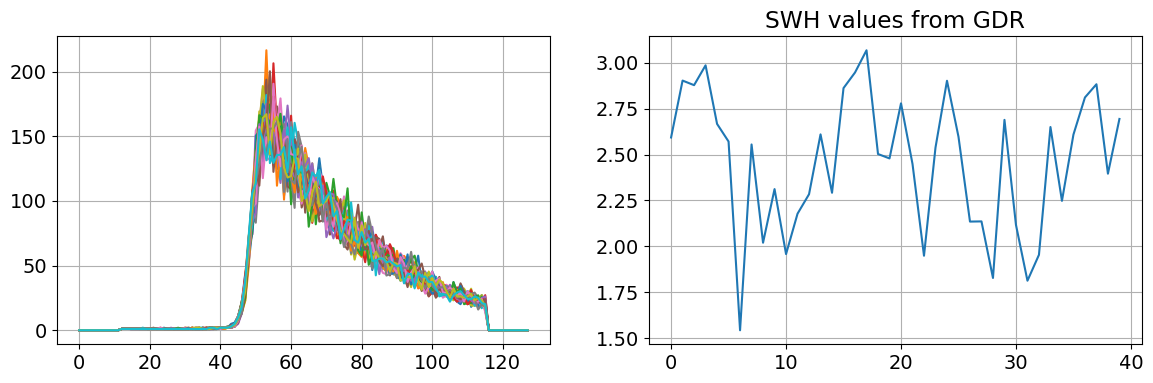

In [83]:
#Now we look at some waveforms ... 
Sg2d=alti_read_l2hrw('saral',file)

fig,axs = plt.subplots(1,2,figsize=(14,4))
ax = axs[0]
ind=2000
im=ax.plot(Sg2d.waveforms[ind,:,:].T)
ax = axs[1]
im=ax.plot(Sg2d.swh2d[ind,:])
ax.set_title('SWH values from GDR')

ax.grid(True)


## 2. Now we look at our WHALES-retracked results

Size of array; (2886, 40)
(2886, 40)
(2886, 40)
median std   (GDR,1,2): 0.3856, 0.2552,0.2552
median mean  (GDR,1,2): 2.6272, 2.7575,2.7570


/tmp/ipykernel_40063/274209176.py:51: RuntimeWarning: All-NaN slice encountered
  Hs1Hz=np.nanmedian(S1.swh_WHALES_20hz[:,:],axis=1)


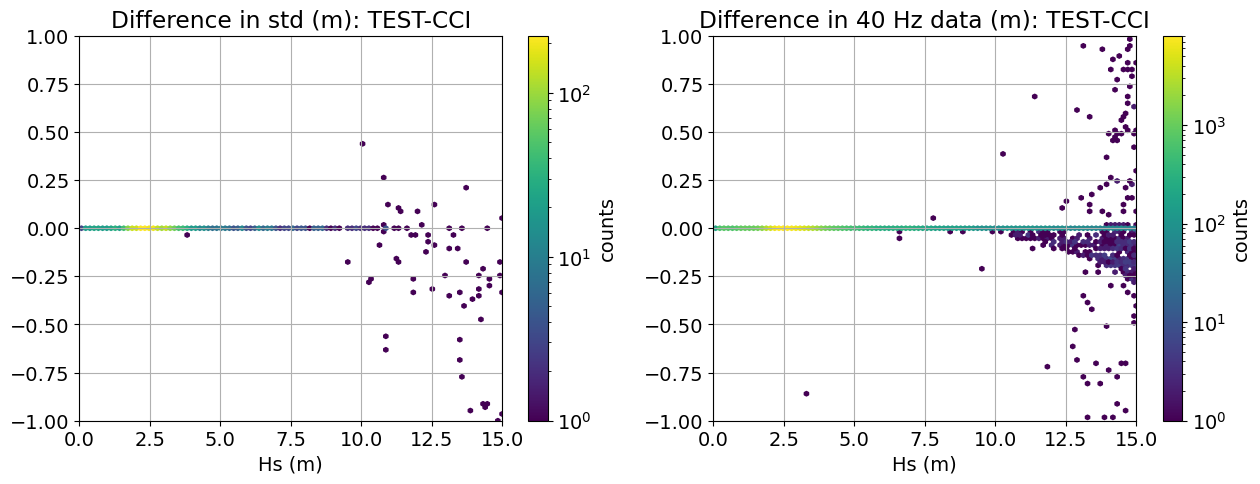

In [91]:
# the files TEST* were obtained as follows (the -d 1 parameter is there to add the weights and normalized waveforms in the output): 
# conda activate seastatecci_whales
# WARNING: set variable in processing_choices: thrb=0.

# This test should reproduce the CCI-v3 result 
# time python ~/TOOLS/cci_whales/src/python_WHALES_launcher.py -m saral -i SRL_GPS_2PfP001_0641_20130405_141055_20130405_150113.CNES.nc -d 1 -s 3 -o TEST

# WARNING: set variable in processing_choices: thrb=0.7 
# time python python_WHALES_launcher.py -m jason2 -i JA2_GPS_2PdP096_139_20110214_101739_20110214_111352.nc -d 1 -o TESTt7 



tag1='CCI'   # this is the CCI v4 as of 2025/01/01
tag2='TEST'  # this is the same thing with the new version of the code.

#tag1='TEST' 
#tag2='TESTs0t7m0w1'   # possible replacement of smoothing with threshold on normalized waveform (more robust ?) 
#tag2='TESTs3t0m0w2'   # possible replacement of smoothing with threshold on normalized waveform (more robust ?) 
#tag2='TESTs0t7m1w2'    #  python ~/TOOLS/cci_whales/src/python_WHALES_launcher.py -m saral -i SRL_GPS_2PfP001_0641_20130405_141055_20130405_150113.CNES.nc -d 1  -w 2 -o TESTs0t7m1w2

file1=tag1+'/'+file      
file2=tag2+'/'+file  
S1 = xr.open_dataset(file1)
print('Size of array;', np.shape(S1.swh_WHALES_20hz))
#file2='/home/ardhuin/PUBLI/2025_SWOTgroups/TESTw3/'+file
S2 = xr.open_dataset(file2)


fig,axs = plt.subplots(1,2,figsize=(15,5))
ax = axs[0]
smax=1;hmax=15
hb=ax.hexbin(np.nanmean(Sg2d.swh2d[:,:],axis=1),np.nanstd(S2.swh_WHALES_20hz[:,:],axis=1)-np.nanstd(S1.swh_WHALES_20hz[:,:],axis=1),extent=(0,hmax,-smax,smax),bins='log') #,gridsize=50)
cb = fig.colorbar(hb, ax=ax, label='counts')
ax.set_xlim((0,hmax))
ax.set_ylim((-smax,smax))
ax.set_title('Difference in std (m): '+tag2+'-'+tag1)
ax.set_xlabel('Hs (m)')

ax = axs[1]
dmax=1
print(np.shape(Sg2d.swh2d[:,:]))
print(np.shape(S1.swh_WHALES_20hz[:,:].values-Sg2d.swh2d[:,:].values))
hb=ax.hexbin(S1.swh_WHALES_20hz[:,:],S2.swh_WHALES_20hz[:,:]-S1.swh_WHALES_20hz[:,:],extent=(0,hmax,-dmax,dmax),bins='log') #,gridsize=50)
# Below : difference plot with GDR 
#hb=ax.hexbin(S1.swh_WHALES_20hz[:,:],S1.swh_WHALES_20hz[:,:].values-Sg2d.swh2d[:,:].values,extent=(0,hmax,-dmax,dmax),bins='log') #,gridsize=50)
cb = fig.colorbar(hb, ax=ax, label='counts')
ax.set_xlim((0,hmax))
ax.set_ylim((-dmax,dmax))
ax.set_title('Difference in 40 Hz data (m): '+tag2+'-'+tag1)
ax.set_xlabel('Hs (m)')
Hs1Hz=np.nanmedian(S1.swh_WHALES_20hz[:,:],axis=1)
Hs1gd=np.nanmean(Sg2d.swh2d[:,:],axis=1)

inds=np.where((Hs1Hz > 0 ))[0] # & (Hs1gd < 1.0) )[0]

print(f"median std   (GDR,1,2): {np.nanmedian(np.nanstd(Sg2d.swh2d[inds,:],axis=1)):.4f}, {np.nanmedian(np.nanstd(S1.swh_WHALES_20hz[inds,:],axis=1)):.4f},{np.nanmedian(np.nanstd(S2.swh_WHALES_20hz[inds,:],axis=1)):.4f}" )
print(f"median mean  (GDR,1,2): {np.nanmedian(np.nanmean(Sg2d.swh2d[inds,:],axis=1)):.4f}, {np.nanmedian(np.nanmean(S1.swh_WHALES_20hz[inds,:],axis=1)):.4f},{np.nanmedian(np.nanmean(S2.swh_WHALES_20hz[inds,:],axis=1)):.4f}" )



TEST: 0.28738168 ## [50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 49 50 49 50 49 50 50]


/tmp/ipykernel_40063/1509135810.py:6: RuntimeWarning: All-NaN slice encountered
  im=ax.plot(np.nanmedian(S1.swh_WHALES_20hz[:,:],axis=1),c='r',label=tag1)
/tmp/ipykernel_40063/1509135810.py:7: RuntimeWarning: All-NaN slice encountered
  im=ax.plot(np.nanmedian(S2.swh_WHALES_20hz[:,:],axis=1),c='k',alpha=0.3,label=tag2)


(45.0, 60.0)

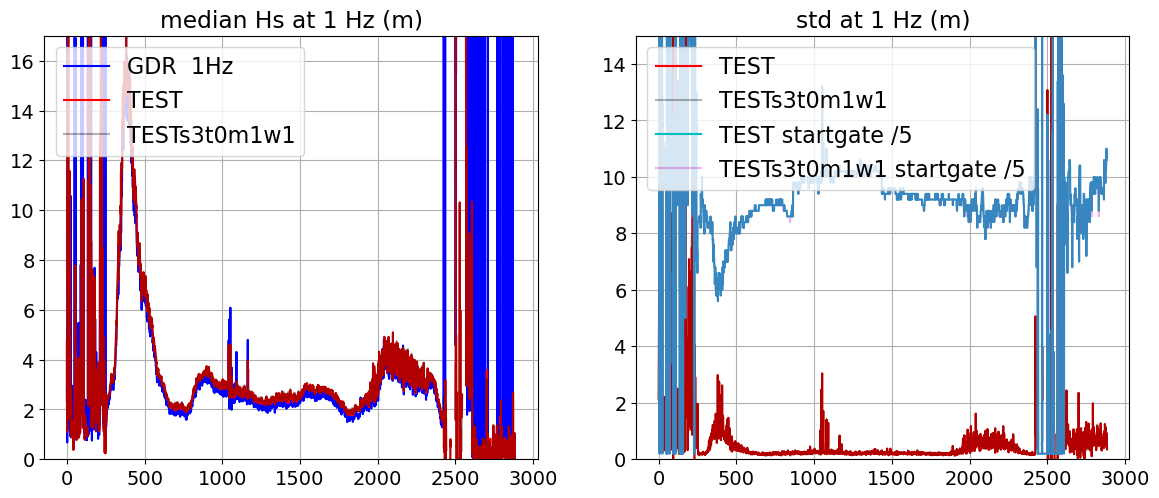

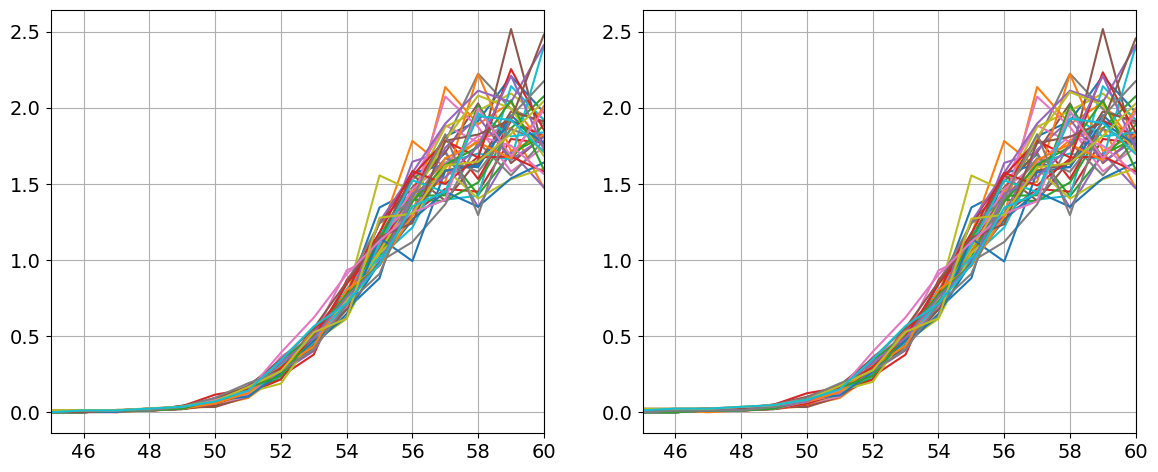

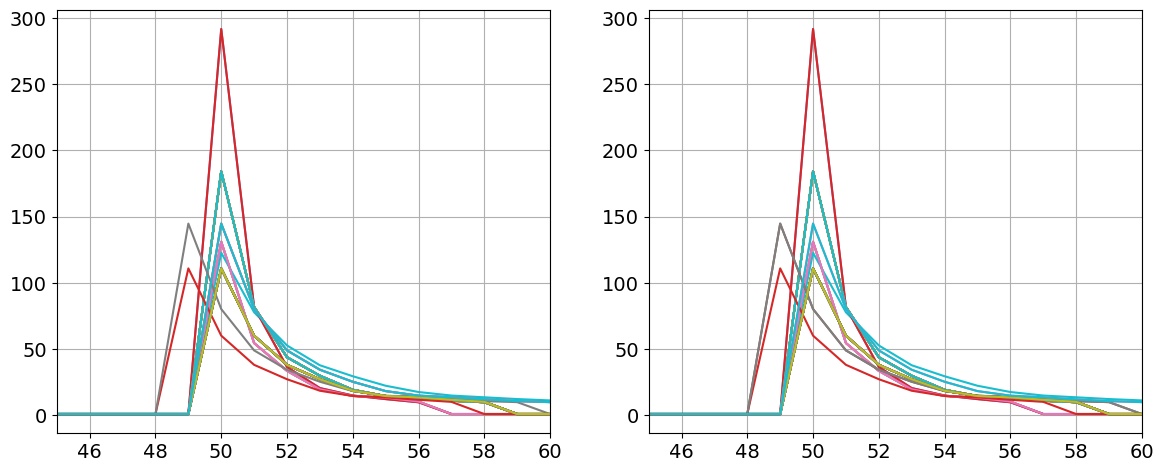

In [57]:
fig,axs = plt.subplots(1,2,figsize=(14,5.5))
ax = axs[0]
#im=ax.scatter(S1.lat_20hz[:,0],S1.swh_WHALES_20hz[:,0])
#im=ax.scatter(S1.lat_20hz[0:-1:20,0],S1.swh_WHALES_20hz[0:-1:20,:])
im=ax.plot(Sgd.swh_1hz,c='b',label='GDR  1Hz')
im=ax.plot(np.nanmedian(S1.swh_WHALES_20hz[:,:],axis=1),c='r',label=tag1)
im=ax.plot(np.nanmedian(S2.swh_WHALES_20hz[:,:],axis=1),c='k',alpha=0.3,label=tag2)
ax.set_title('median Hs at 1 Hz (m)')

#im=ax.plot(5*np.nanstd(S1.swh_WHALES_20hz[:,:],axis=1),c='g',label='std1*5')
#im=ax.plot(5*np.nanstd(S2.swh_WHALES_20hz[:,:],axis=1),c='b',alpha=0.3,label='std2*5')
ax.set_ylim((0,17))
ax.legend(loc='upper left', fontsize=16)

ax = axs[1]
#im=ax.plot(S1.startgate_WHALES[:,0]/5.,tag1+'startgate /5')
im=ax.plot(np.nanstd(S1.swh_WHALES_20hz[:,:],axis=1),c='r',label=tag1)
im=ax.plot(np.nanstd(S2.swh_WHALES_20hz[:,:],axis=1),c='k',alpha=0.3,label=tag2)
im=ax.plot(S1.startgate_WHALES[:,0]/5.,c='c',label=tag1+' startgate /5')
im=ax.plot(S2.startgate_WHALES[:,0]/5.,c='m',alpha=0.3,label=tag2+' startgate /5')
ax.set_ylim((0,15))
ax.set_title('std at 1 Hz (m)')
ax.legend(loc='upper left', fontsize=16)

#im=ax.scatter(np.nanstd(S1.swh_WHALES_20hz[:,:],axis=1),np.nanstd(S2.swh_WHALES_20hz[:,:],axis=1))
#ax.set_xlim((0,1))
#ax.set_xlim((0,130))
#ax.set_ylim((0,100))

ind=1000
print('TEST:',np.nanstd(S1.swh_WHALES_20hz[ind,:]),'##',S2.startgate_WHALES[ind,:].values)
fig,axs = plt.subplots(1,2,figsize=(14,5.5))
ax = axs[0]
im=ax.plot(S1.normalized_waveform[ind,:,:].T)
ax.set_xlim((45,60))
ax = axs[1]
im=ax.plot(S2.normalized_waveform[ind,:,:].T)
ax.set_xlim((45,60))

fig,axs = plt.subplots(1,2,figsize=(14,5.5))
ax = axs[0]
im=ax.plot(S1.weights[ind,:,:].T)
ax.set_xlim((45,60))
ax = axs[1]
im=ax.plot(S2.weights[ind,:,:].T)
ax.set_xlim((45,60))

TEST: 0.28738168 ## 0.2904244


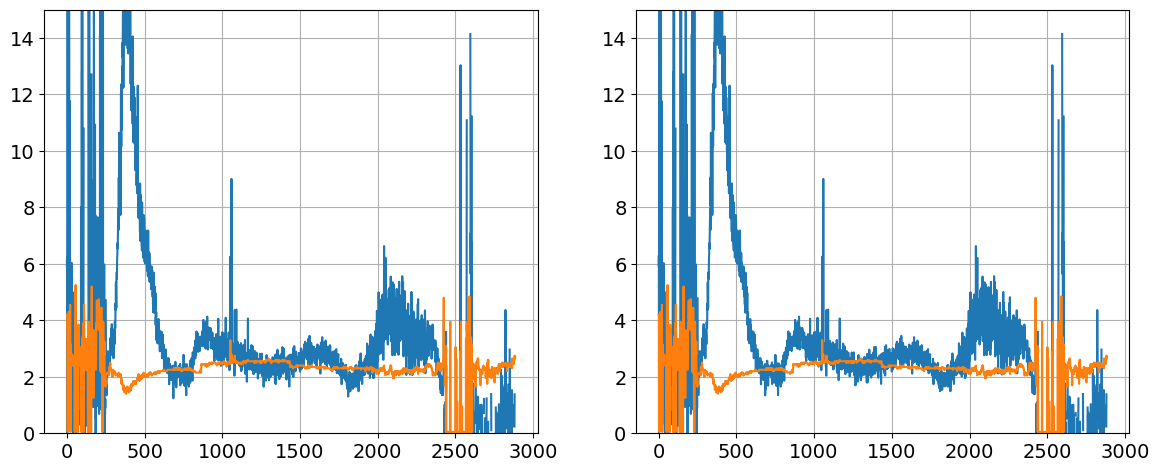

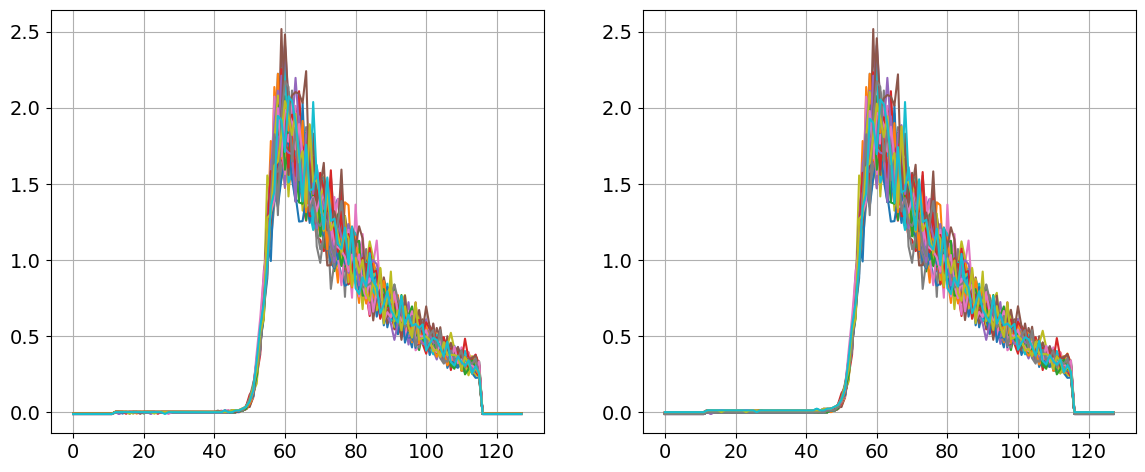

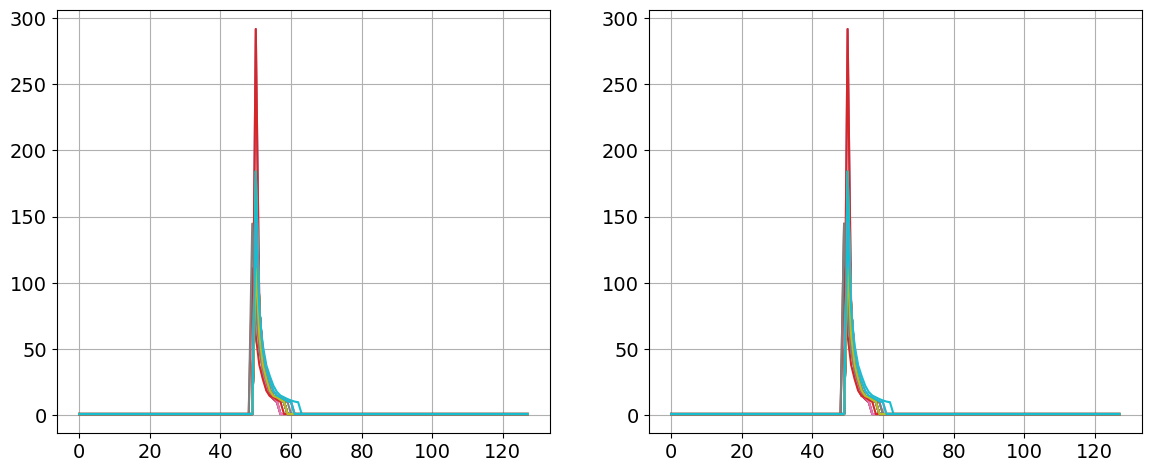

In [58]:
fig,axs = plt.subplots(1,2,figsize=(14,5.5))
ax = axs[0]
#im=ax.scatter(S1.lat_20hz[:,0],S1.swh_WHALES_20hz[:,0])
#im=ax.scatter(S1.lat_20hz[0:-1:20,0],S1.swh_WHALES_20hz[0:-1:20,:])
im=ax.plot(S1.swh_WHALES_20hz[:,0])
#im=ax.plot(S1.startgate_WHALES)
im=ax.plot(S1.startgate_WHALES[:,0]/20.)
ax.set_ylim((0,15))

ax = axs[1]
#im=ax.scatter(S1.lat_20hz[:,0],S1.swh_WHALES_20hz[:,0])
#im=ax.scatter(S1.lat_20hz[0:-1:20,0],S1.swh_WHALES_20hz[0:-1:20,:])
im=ax.plot(S2.swh_WHALES_20hz[:,0])
#im=ax.plot(S1.startgate_WHALES)
im=ax.plot(S2.startgate_WHALES[:,0]/20.)
ax.set_ylim((0,15))

#im=ax.scatter(np.nanstd(S1.swh_WHALES_20hz[:,:],axis=1),np.nanstd(S2.swh_WHALES_20hz[:,:],axis=1))
#ax.set_xlim((0,1))
#ax.set_xlim((0,130))
#ax.set_ylim((0,100))

ind=1000
print('TEST:',np.nanstd(S1.swh_WHALES_20hz[ind,:]),'##',np.nanstd(S2.swh_WHALES_20hz[ind,:]))
fig,axs = plt.subplots(1,2,figsize=(14,5.5))
ax = axs[0]
im=ax.plot(S1.normalized_waveform[ind,:,:].T)
ax = axs[1]
im=ax.plot(S2.normalized_waveform[ind,:,:].T)

fig,axs = plt.subplots(1,2,figsize=(14,5.5))
ax = axs[0]
im=ax.plot(S1.weights[ind,:,:].T)
ax = axs[1]
im=ax.plot(S2.weights[ind,:,:].T)